In [325]:
import pandas as pd
import scipy as sc
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn import linear_model, metrics, preprocessing, model_selection
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, f1_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from collections import Counter

In [326]:
df = pd.read_csv("raw_data.csv")
tempdf = pd.read_csv("data_firsts.csv")
df = pd.concat([df,tempdf])
df = df.copy()
df = df.drop('Unnamed: 0', axis=1) #7510 rows × 42 columns

#Drop duplicated links
df.drop_duplicates(subset='Link', keep='last', inplace=True) #4209 rows × 42 columns

In [327]:
#Drop un-needed rows
df.dropna(thresh = 10, inplace = True)
df.dropna(subset = 'Name Romaji', inplace = True)
df.dropna(subset = 'Start Year', inplace = True)
df.dropna(subset = 'Status', inplace = True) 

#Fixing index col after rows delete
df = df.reset_index() 
df = df.drop('index', axis=1) 

#Filling NaN values before merging 
df['Rating 10'].fillna(0, inplace=True)
df['Rating 20'].fillna(0, inplace=True)
df['Rating 30'].fillna(0, inplace=True)
df['Rating 40'].fillna(0, inplace=True)
df['Rating 50'].fillna(0, inplace=True)
df['Rating 60'].fillna(0, inplace=True)
df['Rating 70'].fillna(0, inplace=True)
df['Rating 80'].fillna(0, inplace=True)
df['Rating 90'].fillna(0, inplace=True)
df['Rating 100'].fillna(0, inplace=True)

#Filling missing numeric values
df['Favorites'].fillna(df['Favorites'].mean(), inplace=True)
df['Rating Rank'].fillna(0, inplace=True)
df['Popularity Rank'].fillna(0, inplace=True)
df['Volume Count'].fillna(df['Volume Count'].mean(), inplace=True)
df['Popularity'].fillna(df['Popularity'].median(), inplace=True)
df['Anime Release Date'].fillna(df['Anime Release Date'].median(), inplace=True)

#Filling missing non-numeric values
df.Source = df.Source.fillna(df.Source.mode()[0])

for i in range(0, df.shape[0]):
    if df.loc[i,'Name English'] is np.nan:
        df.loc[i,'Name English'] = df.loc[i,'Name Romaji']
    if df.loc[i,'Name Native'] is np.nan:
        df.loc[i,'Name Native'] = df.loc[i,'Name Romaji']
    if df.loc[i,'Synonyms'] is np.nan:
        df.loc[i,'Synonyms'] = df.loc[i,'Name Romaji']
    if df.loc[i,'Tag_One'] is np.nan:
        df.loc[i,'Tag_One'] = 'No Tag'
    if df.loc[i,'Tag_Two'] is np.nan:
        df.loc[i,'Tag_Two'] = 'No Tag'
    if df.loc[i,'Tag_Three'] is np.nan:
        df.loc[i,'Tag_Three'] = 'No Tag'
    if df.loc[i,'Genre_One'] is np.nan:
        df.loc[i,'Genre_One'] = 'No Genre'
    if df.loc[i,'Genre_Two'] is np.nan:
        df.loc[i,'Genre_Two'] = 'No Genre'
    if df.loc[i,'Genre_Three'] is np.nan:
        df.loc[i,'Genre_Three'] = 'No Genre'
        
    df['Average Rating'] = (((df['Rating 10'])*10 + (df['Rating 20'])*20 + (df['Rating 30'])*30 + (df['Rating 40'])*40 +
                            (df['Rating 50'])*50 + (df['Rating 60'])*60 + (df['Rating 70'])*70 + (df['Rating 80'])*80 +
                            (df['Rating 90'])*90 + (df['Rating 100'])*100)/((df['Rating 10']) + (df['Rating 20']) + 
                            (df['Rating 30']) + (df['Rating 40']) +(df['Rating 50']) + (df['Rating 60']) + (df['Rating 70'])
                            + (df['Rating 80']) +(df['Rating 90']) + (df['Rating 100']))) #Adding average
    
    #New Column: Does it got an adaptation?
    if ((df.loc[i,'Related 1 Type'] == 'TV · Releasing') or (df.loc[i,'Related 2 Type'] == 'TV · Releasing') or
        (df.loc[i,'Related 1 Type'] == 'Movie · Finished') or (df.loc[i,'Related 2 Type'] == 'Movie · Finished') or
        (df.loc[i,'Related 1 Type'] == 'OVA · Finished') or (df.loc[i,'Related 2 Type'] == 'OVA · Finished') or
        (df.loc[i,'Related 1 Type'] == 'ONA · Finished') or (df.loc[i,'Related 2 Type'] == 'ONA · Finished') or
        (df.loc[i,'Related 1 Type'] == 'ONA · Releasing') or (df.loc[i,'Related 2 Type'] == 'ONA · Releasing') or
        (df.loc[i,'Related 1 Type'] == 'TV Short · Finished') or (df.loc[i,'Related 2 Type'] == 'TV Short · Finished') or
        (df.loc[i,'Related 1 Type'] == 'TV · Finished') or (df.loc[i,'Related 2 Type'] == 'TV · Finished') or
        (df.loc[i,'Related 1 Type'] == 'Special · Finished') or (df.loc[i,'Related 2 Type'] == 'Special · Finished')):
        df.loc[i,'Adaptation'] = 1
    else:
        df.loc[i,'Adaptation'] = 0

for i in range(0, df.shape[0]):
    if np.isnan(df.loc[i,'Average Rating']):
        df.loc[i,'Average Rating'] = df.loc[i,'Mean Score']
    if df.loc[i,'Adaptation'] is np.nan:
        df.loc[i,'Adaptation'] = df.loc[i,'Has Anime']
df['Average Rating'].fillna(df['Average Rating'].mean(), inplace=True)

#Dropping unnecessary columns
df = df.drop(['Rating 10','Rating 20','Rating 30','Rating 40','Rating 50','Rating 60',
             'Rating 70','Rating 80','Rating 90','Rating 100'], axis=1)
df = df.drop('Chapter Count', axis=1)
df = df.drop('End Date', axis=1)
df = df.drop('Average Score', axis=1)
df = df.drop('Mean Score', axis=1)
df = df.drop('Related 1 Type', axis=1)
df = df.drop('Related 2 Type', axis=1)
df = df.drop('Popularity Number', axis=1)
df = df.drop('Rating Number', axis=1)
df = df.drop('Format', axis=1)

#After cleanup: 4078 rows × 25 columns

In [328]:
#Change type to save space
df["Name Romaji"] = df["Name Romaji"].astype('category')
df["Name Native"] = df["Name Native"].astype('category')
df["Name English"] = df["Name English"].astype('category')
df["Synonyms"] = df["Synonyms"].astype('category')
df["Status"] = df["Status"].astype('category')
df["Source"] = df["Source"].astype('category')
df["Genre_One"] = df["Genre_One"].astype('category')
df["Genre_Two"] = df["Genre_Two"].astype('category')
df["Genre_Three"] = df["Genre_Three"].astype('category')
df["Tag_One"] = df["Tag_One"].astype('category')
df["Tag_Two"] = df["Tag_Two"].astype('category')
df["Tag_Three"] = df["Tag_Three"].astype('category')
df["Start Date"] = df["Start Date"].astype('category')
df["Rating Rank"] = df["Rating Rank"].astype('category')
df["Popularity Rank"] = df["Popularity Rank"].astype('category')

replace_map_Genre = {'Drama':1, 'Adventure':2, 'Action':3, 'Comedy':4, 'Mystery':5, 'Romance':6, 'Fantasy':7,
 'Horror':8, 'Sci-Fi':9, 'Psychological':10, 'Ecchi':11, 'Supernatural':12, 'Music':13,
 'Thriller':14, 'Slice of Life':15, 'Sports':16, 'Mahou Shoujo':17, 'Mecha':18, 'No Genre':0}
replace_map_Source = {'Original':1 , 'Manga':2 , 'Visual Novel':3 , 'Video Game':4 , 'Web Novel':5 ,'Other':6 ,
                      'Light Novel':7 ,'Multimedia Project':8 , 'Game':9 , 'Novel':10 , 'Live Action':11 , 'Anime':12}

df.replace(replace_map_Genre, inplace = True)
df.replace(replace_map_Source, inplace = True)

df = pd.get_dummies(df, columns=['Status'], prefix = ['Status'])
#df = pd.get_dummies(df, columns=['Source'], prefix = ['Source'])

In [329]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4078 entries, 0 to 4077
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Name Romaji              4078 non-null   category
 1   Name Native              4078 non-null   category
 2   Name English             4078 non-null   category
 3   Synonyms                 4078 non-null   category
 4   Volume Count             4078 non-null   float64 
 5   Start Date               4078 non-null   category
 6   Start Year               4078 non-null   float64 
 7   Popularity               4078 non-null   float64 
 8   Favorites                4078 non-null   float64 
 9   Source                   4078 non-null   category
 10  Genre_One                4078 non-null   category
 11  Genre_Two                4078 non-null   category
 12  Genre_Three              4078 non-null   category
 13  Tag_One                  4078 non-null   category
 14  Tag_Two 

In [330]:
df['Has Anime'].value_counts(normalize=True)

False    0.850417
True     0.149583
Name: Has Anime, dtype: float64

<AxesSubplot:ylabel='Genre_One'>

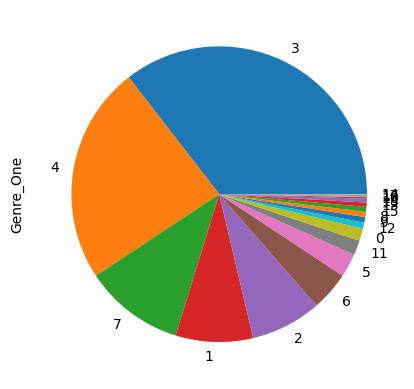

In [331]:
df['Genre_One'].value_counts().plot(kind='pie')

<AxesSubplot:>

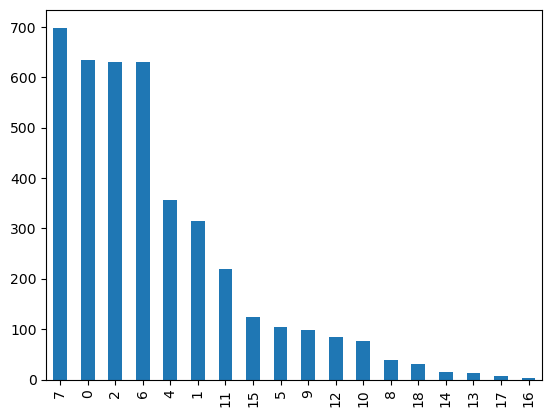

In [332]:
df['Genre_Two'].value_counts().plot(kind='bar')

Text(0, 0.5, 'Average Rating')

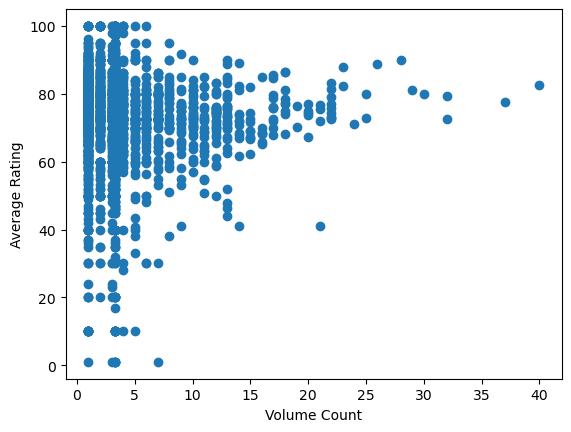

In [333]:
plt.scatter(df['Volume Count'],df['Average Rating'])
plt.xlabel('Volume Count')
plt.ylabel('Average Rating')

Text(0, 0.5, 'Frequency')

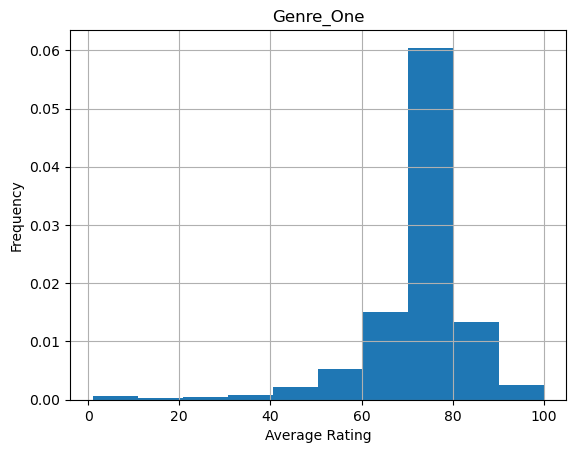

In [334]:
df['Average Rating'].hist(density=True)
plt.title('Genre_One')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

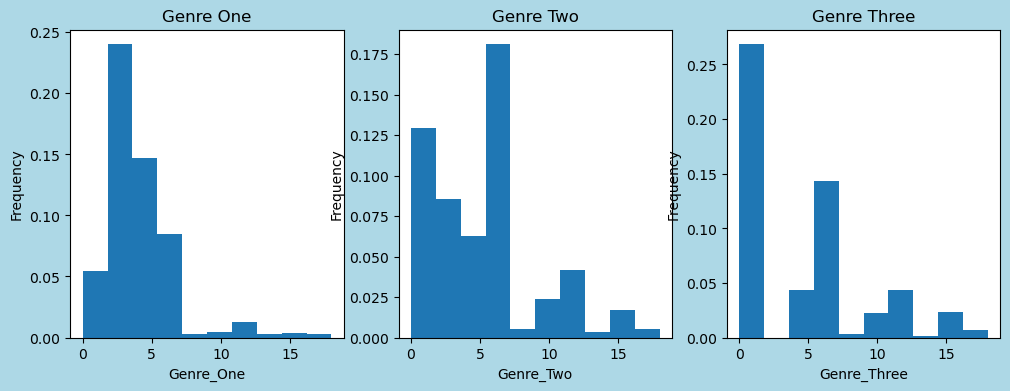

In [351]:
fig = plt.figure(figsize=(12,4))
fig.set_facecolor('lightblue')
fig1 = fig.add_subplot(1,3,1)
fig2 = fig.add_subplot(1,3,2)
fig3 = fig.add_subplot(1,3,3)

fig1.hist(df['Genre_One'], density=True)
fig1.set_title('Genre One')
fig1.set_xlabel('Genre_One')
fig1.set_ylabel('Frequency')

fig2.hist(df['Genre_Two'], density=True)
fig2.set_title('Genre Two')
fig2.set_xlabel('Genre_Two')
fig2.set_ylabel('Frequency')

fig3.hist(df['Genre_Three'], density=True)
fig3.set_title('Genre Three')
fig3.set_xlabel('Genre_Three')
fig3.set_ylabel('Frequency')

In [336]:
df['Average Rating'].value_counts()

72.448721    1370
70.000000     181
80.000000     130
60.000000     104
75.000000      75
             ... 
86.298264       1
85.395683       1
78.454999       1
88.972152       1
75.535714       1
Name: Average Rating, Length: 1018, dtype: int64

In [337]:
df.describe(include='all')

,Name Romaji,Name Native,Name English,Synonyms,Volume Count,Start Date,Start Year,Popularity,Favorites,Source,...,Anime Release Date,Name Word Count,Link,Average Rating,Adaptation,Status_Cancelled,Status_Finished,Status_Hiatus,Status_Not Yet Released,Status_Releasing
count,4078,4078,4078,4078,4078.000000,4078,4078.000000,4078.000000,4078.000000,4078.0,...,4078.000000,4078.000000,4078,4078.000000,4078.000000,4078.000000,4078.000000,4078.000000,4078.000000,4078.000000
unique,4076,4076,4076,4068,NaN,2151,NaN,NaN,NaN,12.0,...,NaN,NaN,4078,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,"Shokugyou, Shounin",魔界帰りの劣等能力者,Denshi Toshi DT,Ao Buta\n青ブタ\nSeishun Buta Yarou Series\n青春ブタ野...,NaN,"Apr 10, 2020",NaN,NaN,NaN,1.0,...,NaN,NaN,https://anilist.co/manga/115898/Kuraki-Kyuuden...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,2,2,4,NaN,12,NaN,NaN,NaN,3649.0,...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,3.288627,NaN,2015.001962,289.659637,20.754139,NaN,...,2013.808975,6.948504,NaN,72.448721,0.141736,0.003923,0.624080,0.005395,0.005150,0.361452
std,NaN,NaN,NaN,NaN,3.213046,NaN,5.923103,1132.973926,90.142019,NaN,...,2.932826,4.887029,NaN,11.085849,0.348822,0.062522,0.484419,0.073260,0.071584,0.480480
min,NaN,NaN,NaN,NaN,1.000000,NaN,1982.000000,1.000000,1.000000,NaN,...,1979.000000,1.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,1.000000,NaN,2013.000000,18.000000,2.000000,NaN,...,2014.000000,3.000000,NaN,70.769231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,3.288627,NaN,2016.000000,46.000000,15.000000,NaN,...,2014.000000,6.000000,NaN,72.448721,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,NaN,NaN,3.288627,NaN,2019.000000,158.750000,20.754139,NaN,...,2014.000000,9.000000,NaN,77.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000


D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Name Word Count'>

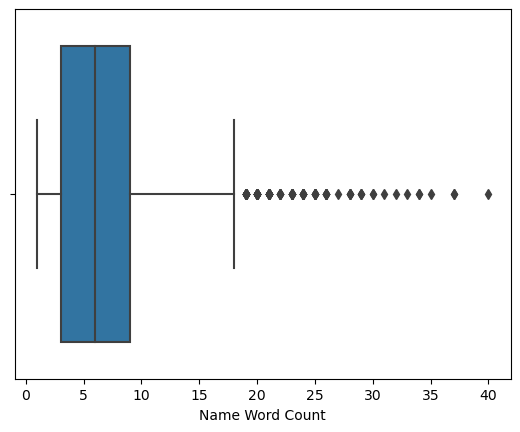

In [338]:
sns.boxplot(df['Name Word Count'])

In [339]:
outliercols = ["Volume Count","Start Year", "Popularity", "Favorites","Anime Release Date","Name Word Count", "Average Rating"]
all_outlier_rows = []
for col in outliercols:
    Q1 = np.percentile(df[col], 25)
    Q3 = np.percentile(df[col], 75)
    IQR = Q3 - Q1
    IQR_range = 1.5 * IQR
    col_outlier = df[(df[col] < Q1 - IQR_range) | (df[col] > Q3 + IQR_range)].index
    all_outlier_rows.extend(col_outlier)
    
len(set(all_outlier_rows))

1709

Text(0, 0.5, 'Has an Anime?')

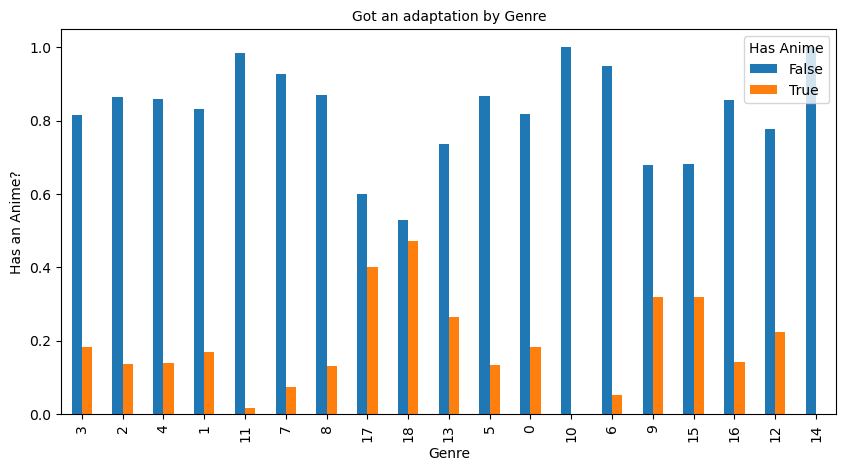

In [355]:
ct1=pd.crosstab(df['Genre_One'],df['Has Anime'],normalize='index')
ct1.plot(kind='bar',figsize=(10,5))
plt.title('Got an adaptation by Genre', fontsize=10)
plt.xlabel('Genre')
plt.ylabel('Has an Anime?')

<AxesSubplot:>

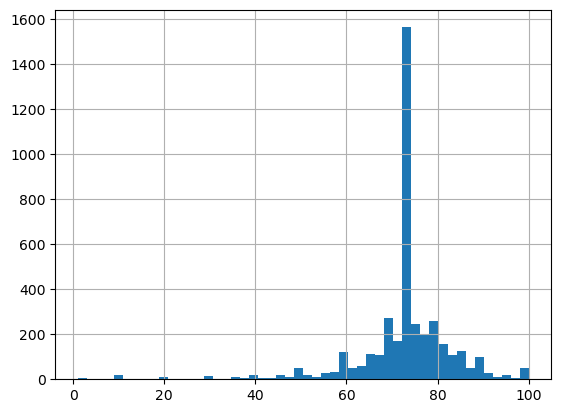

In [341]:
df['Average Rating'].hist(bins=50)
